# Lamp Failure Prediction

In [147]:
# Importation des bibliothèques principales
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Outils de machine learning depuis scikit-learn
from pandas.api.types import is_datetime64_any_dtype

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [148]:
# Définition du chemin vers le fichier CSV
file_path = '../landing/lamp_failure_detection_dataset.csv'

# Chargement du dataset
df = pd.read_csv(file_path)

# Conversion du champ temporel en format datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Aperçu des premières lignes du DataFrame 
df.head()


,bulb_number,timestamp,power_consumption (Watts),voltage_levels (Volts),current_fluctuations (Amperes),temperature (Celsius),environmental_conditions,current_fluctuations_env (Amperes),fault_type
0,1,2023-09-06 07:53:23,106.18,238.52,6.127984,21.97,Rainy,0.780000,1
1,1,2023-03-28 16:28:29,58.71,235.99,3.010000,24.16,Clear,0.100000,0
2,1,2023-09-20 19:17:46,195.49,234.97,1.060000,13.64,Rainy,0.920000,0
3,1,2023-02-03 18:19:43,95.64,225.74,2.160000,15.82,Rainy,3.060000,0
4,1,2023-01-12 13:43:48,70.92,218.76,1.830000,19.12,Rainy,6.529021,4


In [149]:
# Nettoyage approfondi des données
numeric_cols = [
    'power_consumption (Watts)',
    'voltage_levels (Volts)',
    'current_fluctuations (Amperes)',
    'temperature (Celsius)',
    'current_fluctuations_env (Amperes)'
]
categorical_cols = ['environmental_conditions', 'fault_type']

# Suppression des doublons pour éviter les observations redondantes
before_duplicates = df.shape[0]
df.drop_duplicates(inplace=True)
after_duplicates = df.shape[0]
df.reset_index(drop=True, inplace=True)
print(f'Duplicates removed: {before_duplicates - after_duplicates}')

# Conversion explicite des colonnes numériques
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Rapport des valeurs manquantes avant imputation
missing_report = df[numeric_cols + categorical_cols].isnull().sum()
print('Missing values before cleaning:', missing_report)

# Imputation des valeurs manquantes : médiane pour les numériques, mode pour les catégorielles
for col in numeric_cols:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)
for col in categorical_cols:
    if df[col].isnull().any():
        mode = df[col].mode()
        if not mode.empty:
            df[col].fillna(mode[0], inplace=True)

# Détection et limitation des valeurs aberrantes via l'IQR pour stabiliser les distributions
for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        continue
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[col] = df[col].clip(lower_bound, upper_bound)

# Harmonisation des types
for col in categorical_cols:
    df[col] = df[col].astype('category')

clean_missing_report = df[numeric_cols + categorical_cols].isnull().sum()
print('Missing values after cleaning:', clean_missing_report)
print('DataFrame shape after cleaning:', df.shape)

Duplicates removed: 0
Missing values before cleaning: power_consumption (Watts)             0
voltage_levels (Volts)                0
current_fluctuations (Amperes)        0
temperature (Celsius)                 0
current_fluctuations_env (Amperes)    0
environmental_conditions              0
fault_type                            0
dtype: int64
Missing values after cleaning: power_consumption (Watts)             0
voltage_levels (Volts)                0
current_fluctuations (Amperes)        0
temperature (Celsius)                 0
current_fluctuations_env (Amperes)    0
environmental_conditions              0
fault_type                            0
dtype: int64
DataFrame shape after cleaning: (34310, 9)


In [150]:
# Enregistrement du jeu de données nettoyé
cleaned_csv_path = '../landing/lamp_failure_detection_dataset_cleaned.csv'
df.to_csv(cleaned_csv_path, index=False)
print(f"Données nettoyées enregistrées dans {cleaned_csv_path}")


Données nettoyées enregistrées dans ../landing/lamp_failure_detection_dataset_cleaned.csv


In [151]:
# Statistiques descriptives du jeu de données
df.describe()

,bulb_number,timestamp,power_consumption (Watts),voltage_levels (Volts),current_fluctuations (Amperes),temperature (Celsius),current_fluctuations_env (Amperes)
count,34310.000000,34310,34310.000000,34310.000000,34310.000000,34310.000000,34310.000000
mean,47.500000,2023-07-02 22:07:46.138210560,123.089437,225.693761,2.658497,20.026780,2.858448
min,1.000000,2023-01-01 00:33:30,21.518042,210.000000,0.000000,10.000000,0.000000
25%,24.000000,2023-04-03 13:44:37.750000128,85.929269,217.740000,1.310000,15.020000,1.400000
50%,47.500000,2023-07-02 15:20:40,123.241718,225.660000,2.600000,20.040000,2.800000
75%,71.000000,2023-10-01 08:58:27,160.149951,233.250000,3.900000,25.030000,4.110000
max,94.000000,2023-12-31 23:46:21,200.000000,256.515000,7.785000,30.000000,8.175000
std,27.134323,NaN,43.484856,9.320931,1.625335,5.772737,1.782947


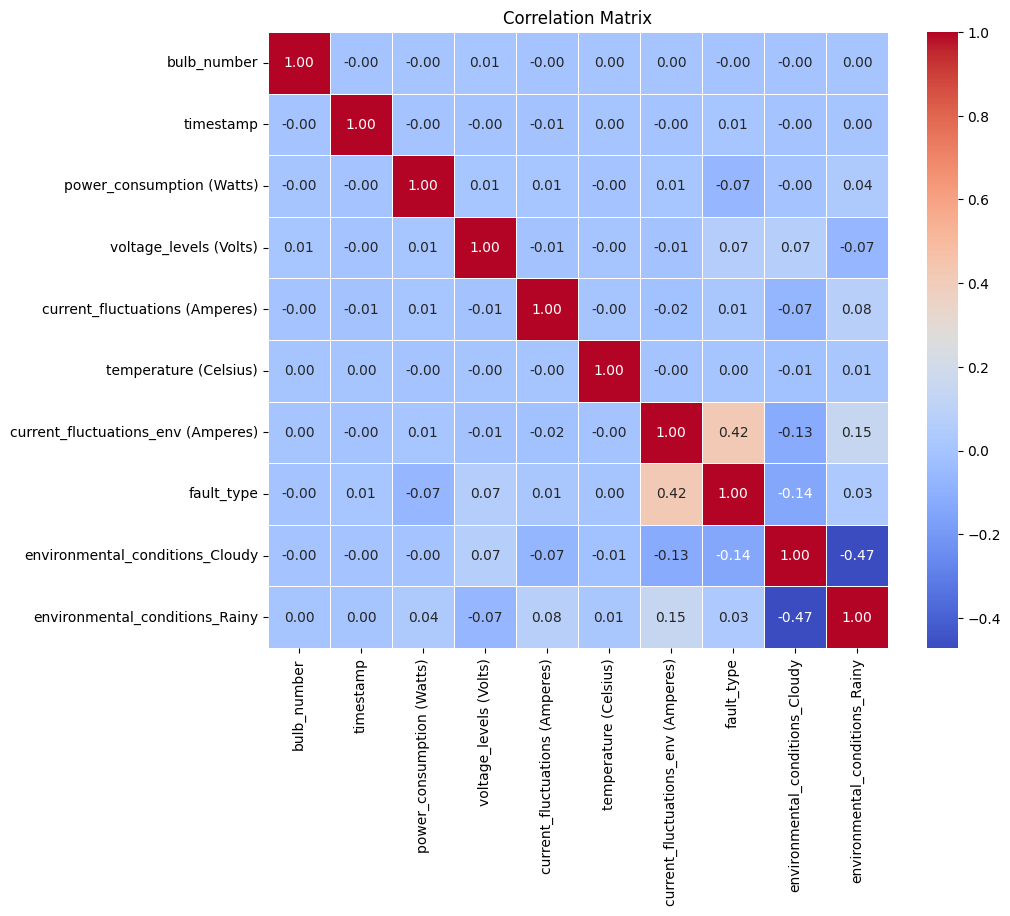

In [152]:
# Encodage des variables catégorielles
df1 = pd.get_dummies(df, columns=['environmental_conditions'], drop_first=True)

# Calcul de la matrice de corrélation
correlation_matrix = df1.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# Titre du graphique
plt.title("Correlation Matrix")
# Affiche la heatmap à l’écran
plt.show()

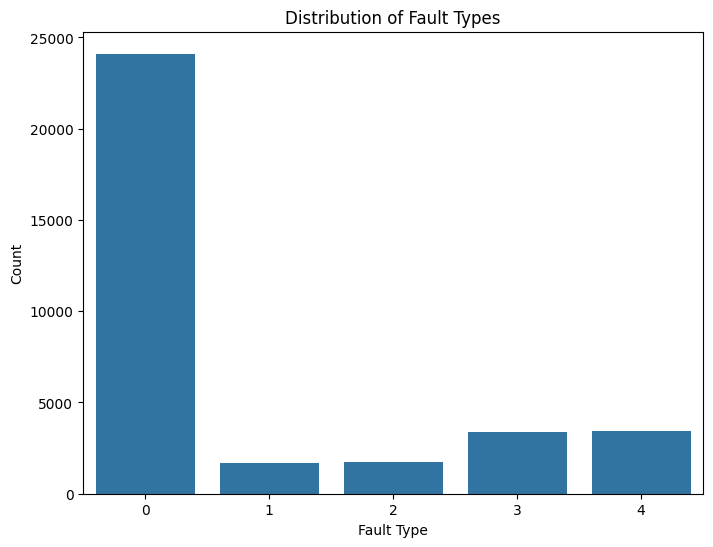

In [153]:
# Visualisation de la répartition des types de pannes
plt.figure(figsize=(8, 6)) # Définit la taille de la figure

# Crée un diagramme en barres montrant le nombre d’occurrences de chaque type de panne dans la colonne 'fault_type'
sns.countplot(x='fault_type', data=df)

# Titre du graphique
plt.title("Distribution of Fault Types")

# Étiquette de l’axe des abscisses
plt.xlabel("Fault Type")

# Étiquette de l’axe des ordonnées
plt.ylabel("Count")

# Affiche le graphique
plt.show()

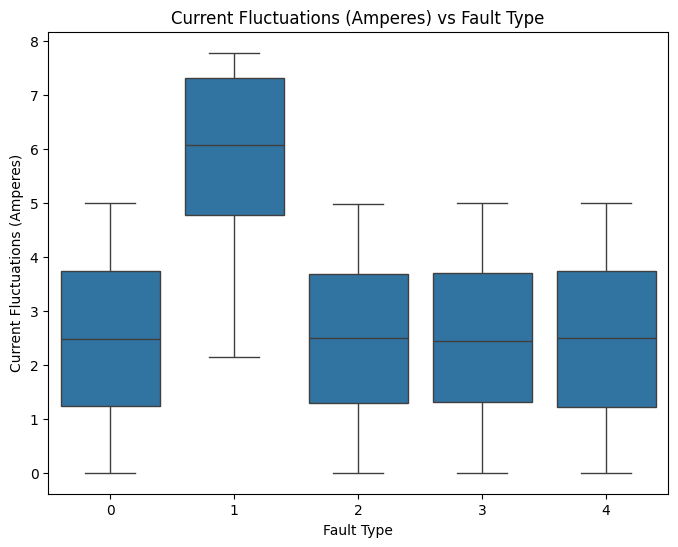

In [154]:
# Visualisation de la relation entre le type de panne et les fluctuations de courant
plt.figure(figsize=(8, 6))  # Définition de la taille du graphique

# Création d’un boxplot pour visualiser la distribution des fluctuations de courant (ampères) en fonction des différents types de pannes (fault_type)
sns.boxplot(x='fault_type', y='current_fluctuations (Amperes)', data=df)

# Ajout d’un titre
plt.title("Current Fluctuations (Amperes) vs Fault Type")

# Étiquettes des axes
plt.xlabel("Fault Type")  # Axe X : les différents types de pannes
plt.ylabel("Current Fluctuations (Amperes)")  # Axe Y : intensité du courant

# Affichage du graphique
plt.show()

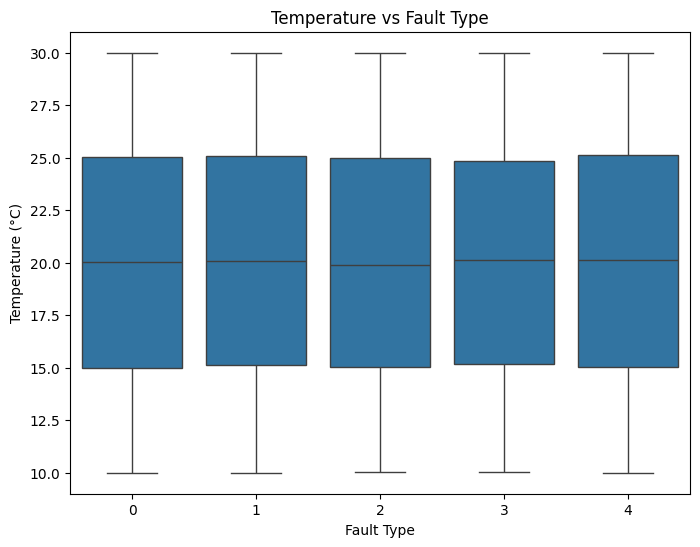

In [155]:
# Visualisation de la relation entre le type de panne et la température
plt.figure(figsize=(8, 6))  # Définition de la taille du graphique

# Création d’un boxplot pour visualiser la distribution de la température (°C) en fonction des différents types de pannes (fault_type)
sns.boxplot(x='fault_type', y='temperature (Celsius)', data=df)

# Ajout d’un titre
plt.title("Temperature vs Fault Type")

# Étiquettes des axes
plt.xlabel("Fault Type")  # Axe X : les différents types de pannes
plt.ylabel("Temperature (°C)")  # Axe Y : température en degrés Celsius

# Affichage du graphique
plt.show()

In [156]:
# Copier le DataFrame pour chaque modèle
df_rf = df.copy(deep=True)   # Pour Random Forest
df_lr = df.copy(deep=True)   # Pour Logistic Regression

# Logistic Regression

In [157]:
# Définition des variables explicatives (features) et de la cible (target)
features_lr = ['power_consumption (Watts)', 'voltage_levels (Volts)', 'current_fluctuations (Amperes)', 'temperature (Celsius)', 'current_fluctuations_env (Amperes)']
target = 'fault_type'

# Nettoyage et conversion des données numériques
for feature in features_lr:
    df_lr[feature] = pd.to_numeric(df_lr[feature].astype(str).replace('[^0-9.]', '', regex=True), errors='coerce')

# Encodage des variables catégorielles
df_lr = pd.get_dummies(df_lr, columns=['environmental_conditions'], drop_first=True)

# Préparation des données
X = df_lr[features_lr + list(df_lr.columns[df_lr.columns.str.startswith('environmental_conditions')])]
y = df_lr[target]

# Standardisation des features numériques pour la régression logistique
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation en train / test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Entraînement du modèle
log_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
log_model.fit(X_train, y_train)

# Prédiction
y_pred = log_model.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)

print(f"Accuracy (Logistic Regression): {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy (Logistic Regression): 0.83

Confusion Matrix:
[[4835    0    0    0   28]
 [  90  222    0    0    1]
 [ 180    0  135    0    0]
 [ 663    0    0    0    0]
 [ 224    0    0    0  484]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      4863
           1       1.00      0.71      0.83       313
           2       1.00      0.43      0.60       315
           3       0.00      0.00      0.00       663
           4       0.94      0.68      0.79       708

    accuracy                           0.83      6862
   macro avg       0.75      0.56      0.62      6862
weighted avg       0.76      0.83      0.78      6862



/Users/gaowen/Downloads/Hackathon-October/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [158]:
# Liste des exemples manuels
manual_examples_lr = [
    {
        'power_consumption (Watts)': 48.423,
        'voltage_levels (Volts)': 218.93,
        'current_fluctuations (Amperes)': 3.01,
        'temperature (Celsius)': 28.34,
        'current_fluctuations_env (Amperes)': 1.95,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 176.39,
        'voltage_levels (Volts)': 213.09,
        'current_fluctuations (Amperes)': 3.64,
        'temperature (Celsius)': 23.2,
        'current_fluctuations_env (Amperes)': 7.106,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 157.14,
        'voltage_levels (Volts)': 228.39,
        'current_fluctuations (Amperes)': 6.849,
        'temperature (Celsius)': 24.38,
        'current_fluctuations_env (Amperes)': 1.06,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 107.45,
        'voltage_levels (Volts)': 248.126,
        'current_fluctuations (Amperes)': 0.7,
        'temperature (Celsius)': 23.36,
        'current_fluctuations_env (Amperes)': 4.77,
        'environmental_conditions_Cloudy': 1,
        'environmental_conditions_Rainy': 0
    },
    {
        'power_consumption (Watts)': 187.86,
        'voltage_levels (Volts)': 212.43,
        'current_fluctuations (Amperes)': 4.28,
        'temperature (Celsius)': 21.59,
        'current_fluctuations_env (Amperes)': 2.04,
        'environmental_conditions_Cloudy': 0,
        'environmental_conditions_Rainy': 1
    }
]

# Création du DataFrame
manual_df_lr = pd.DataFrame(manual_examples_lr)

# Standardisation des valeurs numériques
manual_scaled = scaler.transform(manual_df_lr)

# Prédiction
manual_preds = log_model.predict(manual_scaled)

# Affichage des résultats
for i, pred in enumerate(manual_preds, 1):
    print(f"Manual Example {i} - Predicted Fault Type: {pred}")


Manual Example 1 - Predicted Fault Type: 0
Manual Example 2 - Predicted Fault Type: 4
Manual Example 3 - Predicted Fault Type: 1
Manual Example 4 - Predicted Fault Type: 2
Manual Example 5 - Predicted Fault Type: 0


# Random Forest

In [159]:
# Définition des variables explicatives (features) et de la cible (target)
features_rf = ['power_consumption (Watts)', 'voltage_levels (Volts)', 'current_fluctuations (Amperes)', 'temperature (Celsius)', 'current_fluctuations_env (Amperes)']
target = 'fault_type'

# Nettoyage et conversion des données numériques
for feature in features_rf:
    df_rf[feature] = pd.to_numeric(df_rf[feature].astype(str).replace('[^0-9.]', '', regex=True), errors='coerce')


# Encodage des variables catégorielles
df_rf = pd.get_dummies(df_rf, columns=['environmental_conditions'], drop_first=True)

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_rf[features_rf + list(df_rf.columns[df_rf.columns.str.startswith('environmental_conditions')])], df_rf[target], test_size=0.2, random_state=42)

# Entraînement du modèle Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Prédiction sur l’ensemble de test
y_pred = rf_model.predict(X_test)

# Évaluation du modèle
# Mesure la proportion de bonnes prédictions
accuracy = accuracy_score(y_test, y_pred)
# Compare les prédictions vs les vraies classes pour chaque type de panne
conf_matrix = confusion_matrix(y_test, y_pred)
# Fournit précision, rappel et F1-score pour chaque classe
class_report = classification_report(y_test, y_pred)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



Accuracy: 0.85

Confusion Matrix:
[[4841    0    0   20    2]
 [  78  235    0    0    0]
 [ 160    0  154    1    0]
 [ 570    0    0   93    0]
 [ 220    0    0    0  488]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4863
           1       1.00      0.75      0.86       313
           2       1.00      0.49      0.66       315
           3       0.82      0.14      0.24       663
           4       1.00      0.69      0.81       708

    accuracy                           0.85      6862
   macro avg       0.93      0.61      0.69      6862
weighted avg       0.86      0.85      0.82      6862



In [160]:
# Affichage des noms de variables utilisés pendant l'entraînement du modèle
print("Feature names during model training:")
print(rf_model.feature_names_in_)


Feature names during model training:
['power_consumption (Watts)' 'voltage_levels (Volts)'
 'current_fluctuations (Amperes)' 'temperature (Celsius)'
 'current_fluctuations_env (Amperes)' 'environmental_conditions_Cloudy'
 'environmental_conditions_Rainy']


In [161]:
# Création d’un dictionnaire avec des valeurs manuelles pour prédiction
manual_values = {
    'power_consumption (Watts)': 48.423,
    'voltage_levels (Volts)': 218.93,
    'current_fluctuations (Amperes)': 3.01,
    'temperature (Celsius)': 28.34,
    'current_fluctuations_env (Amperes)': 1.95,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df = pd.DataFrame([manual_values])

# Assurer la conversion en valeurs numériques pour les colonnes de features
for feature in features_rf:
    manual_df[feature] = pd.to_numeric(manual_df[feature], errors='coerce')

# Prédiction avec le modèle Random Forest
manual_pred = rf_model.predict(manual_df)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred[0])


Manual Prediction:
Predicted Fault Type: 3


In [162]:
# Création d’un second exemple manuel pour prédiction
manual_values_2 = {
    'power_consumption (Watts)': 176.39,
    'voltage_levels (Volts)': 213.09,
    'current_fluctuations (Amperes)': 3.64,
    'temperature (Celsius)': 23.2,
    'current_fluctuations_env (Amperes)': 7.106,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df_2 = pd.DataFrame([manual_values_2])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_2[feature] = pd.to_numeric(manual_df_2[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_2 = rf_model.predict(manual_df_2)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_2[0])


Manual Prediction:
Predicted Fault Type: 4


In [163]:
# Création d’un troisième exemple manuel pour prédiction
manual_values_3 = {
    'power_consumption (Watts)': 157.14,
    'voltage_levels (Volts)': 228.39,
    'current_fluctuations (Amperes)': 6.849,
    'temperature (Celsius)': 24.38,
    'current_fluctuations_env (Amperes)': 1.06,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df_3 = pd.DataFrame([manual_values_3])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_3[feature] = pd.to_numeric(manual_df_3[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_3 = rf_model.predict(manual_df_3)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_3[0])


Manual Prediction:
Predicted Fault Type: 1


In [164]:
# Création d’un quatrième exemple manuel pour prédiction
manual_values_4 = {
    'power_consumption (Watts)': 107.45,
    'voltage_levels (Volts)': 248.126,
    'current_fluctuations (Amperes)': 0.7,
    'temperature (Celsius)': 23.36,
    'current_fluctuations_env (Amperes)': 4.77,
    'environmental_conditions_Cloudy': True,
    'environmental_conditions_Rainy': False
}

# Conversion du dictionnaire en DataFrame
manual_df_4 = pd.DataFrame([manual_values_4])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_4[feature] = pd.to_numeric(manual_df_4[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_4 = rf_model.predict(manual_df_4)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_4[0])


Manual Prediction:
Predicted Fault Type: 2


In [165]:
# Création d’un cinquième exemple manuel pour prédiction 
manual_values_5 = {
    'power_consumption (Watts)': 187.86,
    'voltage_levels (Volts)': 212.43,
    'current_fluctuations (Amperes)': 4.28,
    'temperature (Celsius)': 21.59,
    'current_fluctuations_env (Amperes)': 2.04,
    'environmental_conditions_Cloudy': False,
    'environmental_conditions_Rainy': True
}

# Conversion du dictionnaire en DataFrame
manual_df_5 = pd.DataFrame([manual_values_5])

# Conversion des colonnes de features en valeurs numériques
for feature in features_rf:
    manual_df_5[feature] = pd.to_numeric(manual_df_5[feature], errors='coerce')

# Prédiction du type de panne avec le modèle Random Forest
manual_pred_5 = rf_model.predict(manual_df_5)

# Affichage du résultat
print("Manual Prediction:")
print("Predicted Fault Type:", manual_pred_5[0])


Manual Prediction:
Predicted Fault Type: 0


## Remaining Useful Life Regression

Estimating the hours remaining until the next failure for each lamp based on historical sensor readings.


In [166]:
# Construct regression target: hours until the next failure
regression_df = df.copy()
regression_df = regression_df.sort_values(['bulb_number', 'timestamp']).reset_index(drop=True)
regression_df['is_fault'] = regression_df['fault_type'] != 0

regression_df['failure_timestamp'] = regression_df['timestamp'].where(regression_df['is_fault'])
regression_df['next_fault_ts'] = (
    regression_df.groupby('bulb_number')['failure_timestamp']
    .transform(lambda s: s.bfill())
)

regression_df['target_remaining_time'] = (
    (regression_df['next_fault_ts'] - regression_df['timestamp']).dt.total_seconds() / 3600.0
)

regression_df['prev_timestamp'] = regression_df.groupby('bulb_number')['timestamp'].shift(1)
regression_df['hours_since_prev_reading'] = (
    (regression_df['timestamp'] - regression_df['prev_timestamp']).dt.total_seconds() / 3600.0
)
regression_df['hours_since_prev_reading'].fillna(0.0, inplace=True)

regression_df['last_fault_ts'] = regression_df['timestamp'].where(regression_df['is_fault'])
regression_df['last_fault_ts'] = (
    regression_df.groupby('bulb_number')['last_fault_ts']
    .transform(lambda s: s.ffill())
)
regression_df['hours_since_last_fault'] = (
    (regression_df['timestamp'] - regression_df['last_fault_ts']).dt.total_seconds() / 3600.0
)
regression_df['hours_since_last_fault'] = regression_df['hours_since_last_fault'].fillna(
    regression_df['hours_since_prev_reading']
)

regression_df['failure_interval_hours'] = (
    (regression_df['next_fault_ts'] - regression_df['last_fault_ts']).dt.total_seconds() / 3600.0
)
regression_df['failure_interval_hours'] = regression_df['failure_interval_hours'].fillna(
    regression_df['target_remaining_time'] + regression_df['hours_since_last_fault']
)

regression_df = regression_df[
    regression_df['target_remaining_time'].notna()
    & (regression_df['target_remaining_time'] > 0)
].copy()

regression_df.drop(
    columns=['failure_timestamp', 'is_fault', 'next_fault_ts', 'prev_timestamp', 'last_fault_ts'],
    inplace=True
)
regression_df.head()


/var/folders/gq/w_g3zyld0gqdj67phd2tkjhw0000gn/T/ipykernel_53333/3910898673.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  regression_df['hours_since_prev_reading'].fillna(0.0, inplace=True)


,bulb_number,timestamp,power_consumption (Watts),voltage_levels (Volts),current_fluctuations (Amperes),temperature (Celsius),environmental_conditions,current_fluctuations_env (Amperes),fault_type,target_remaining_time,hours_since_prev_reading,hours_since_last_fault,failure_interval_hours
0,1,2023-01-01 15:45:49,69.12,221.92,3.99,13.00,Rainy,1.15,0,39.191667,0.000000,0.000000,39.191667
1,1,2023-01-02 06:14:54,123.88,215.86,3.61,15.62,Rainy,0.12,0,24.706944,14.484722,14.484722,39.191667
2,1,2023-01-03 03:40:53,113.21,236.78,4.09,16.84,Clear,1.30,0,3.273889,21.433056,21.433056,24.706944
4,1,2023-01-03 19:01:24,75.98,223.02,1.99,22.32,Clear,3.18,0,180.309722,12.068056,12.068056,192.377778
5,1,2023-01-04 03:28:42,95.84,236.30,4.98,17.37,Rainy,2.24,0,171.854722,8.455000,20.523056,192.377778


In [167]:
# Feature engineering with rolling statistics and categorical encodings
window = 3
for col in numeric_cols:
    mean_col = f'{col}_rolling_mean_{window}'
    std_col = f'{col}_rolling_std_{window}'
    regression_df[mean_col] = (
        regression_df.groupby('bulb_number')[col]
        .transform(lambda s: s.rolling(window=window, min_periods=1).mean())
    )
    regression_df[std_col] = (
        regression_df.groupby('bulb_number')[col]
        .transform(lambda s: s.rolling(window=window, min_periods=1).std())
    )
    regression_df[std_col].fillna(0.0, inplace=True)

regression_model_df = pd.get_dummies(
    regression_df,
    columns=['environmental_conditions'],
    drop_first=True
)

datetime_cols = [
    col for col in regression_model_df.columns
    if is_datetime64_any_dtype(regression_model_df[col])
]

feature_cols_regression = [
    col for col in regression_model_df.columns
    if col not in ['target_remaining_time', 'timestamp', 'fault_type', 'bulb_number']
    and col not in datetime_cols
]

bool_feature_cols = regression_model_df[feature_cols_regression].select_dtypes(include=['bool']).columns
if len(bool_feature_cols) > 0:
    regression_model_df[bool_feature_cols] = regression_model_df[bool_feature_cols].astype(int)

feature_cols_regression


/var/folders/gq/w_g3zyld0gqdj67phd2tkjhw0000gn/T/ipykernel_53333/1470904948.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  regression_df[std_col].fillna(0.0, inplace=True)
/var/folders/gq/w_g3zyld0gqdj67phd2tkjhw0000gn/T/ipykernel_53333/1470904948.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

['power_consumption (Watts)',
 'voltage_levels (Volts)',
 'current_fluctuations (Amperes)',
 'temperature (Celsius)',
 'current_fluctuations_env (Amperes)',
 'hours_since_prev_reading',
 'hours_since_last_fault',
 'failure_interval_hours',
 'power_consumption (Watts)_rolling_mean_3',
 'power_consumption (Watts)_rolling_std_3',
 'voltage_levels (Volts)_rolling_mean_3',
 'voltage_levels (Volts)_rolling_std_3',
 'current_fluctuations (Amperes)_rolling_mean_3',
 'current_fluctuations (Amperes)_rolling_std_3',
 'temperature (Celsius)_rolling_mean_3',
 'temperature (Celsius)_rolling_std_3',
 'current_fluctuations_env (Amperes)_rolling_mean_3',
 'current_fluctuations_env (Amperes)_rolling_std_3',
 'environmental_conditions_Cloudy',
 'environmental_conditions_Rainy']

In [168]:
# Train a regression model to predict remaining time until failure
X_reg = regression_model_df[feature_cols_regression].astype(float)
y_reg = regression_model_df['target_remaining_time']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

rfr_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rfr_model.fit(X_train_reg, y_train_reg)

y_pred_reg = rfr_model.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
mae = mean_absolute_error(y_test_reg, y_pred_reg)

print(f'RMSE: {rmse:.2f} hours')
print(f'MAE: {mae:.2f} hours')

rf_metrics = {
    'name': 'RandomForestRegressor',
    'model': rfr_model,
    'rmse': rmse,
    'mae': mae
}


RMSE: 3.40 hours
MAE: 1.02 hours


In [169]:
# Alternative model: HistGradientBoostingRegressor for improved accuracy
hgb_model = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=8,
    max_leaf_nodes=31,
    min_samples_leaf=20,
    random_state=42
)
hgb_model.fit(X_train_reg, y_train_reg)

y_pred_hgb = hgb_model.predict(X_test_reg)
rmse_hgb = np.sqrt(mean_squared_error(y_test_reg, y_pred_hgb))
mae_hgb = mean_absolute_error(y_test_reg, y_pred_hgb)

print(f'HistGradientBoosting RMSE: {rmse_hgb:.2f} hours')
print(f'HistGradientBoosting MAE: {mae_hgb:.2f} hours')

cv_mae = -cross_val_score(
    HistGradientBoostingRegressor(**hgb_model.get_params()),
    X_reg,
    y_reg,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
print(f'Cross-validated MAE (3-fold): {cv_mae.mean():.2f} ± {cv_mae.std():.2f}')

hgb_metrics = {
    'name': 'HistGradientBoostingRegressor',
    'model': hgb_model,
    'rmse': rmse_hgb,
    'mae': mae_hgb
}


HistGradientBoosting RMSE: 6.26 hours
HistGradientBoosting MAE: 2.49 hours
Cross-validated MAE (3-fold): 3.03 ± 0.30


In [170]:
# Select the best-performing model based on MAE
model_candidates = [rf_metrics, hgb_metrics]
best_model_info = min(model_candidates, key=lambda item: item['mae'])
best_model = best_model_info['model']
print(f"Best model selected: {best_model_info['name']} (MAE={best_model_info['mae']:.2f} hours)")


Best model selected: RandomForestRegressor (MAE=1.02 hours)


In [185]:
# Example prediction for the most recent reading of a single lamp
latest_per_bulb = (
    regression_model_df.sort_values(['bulb_number', 'timestamp'])
    .groupby('bulb_number')
    .tail(1)
)

example_row = latest_per_bulb.sample(1)
example_features = example_row[feature_cols_regression]
predicted_remaining = best_model.predict(example_features)[0]
actual_remaining = example_row['target_remaining_time'].iloc[0]
bulb_id = int(example_row['bulb_number'].iloc[0])
timestamp_value = example_row['timestamp'].iloc[0]

print(f'Selected Bulb: {bulb_id}')
print(f'Timestamp: {timestamp_value}')
print(f'Predicted Remaining Time: {predicted_remaining:.1f} hours')
print(f'Actual Remaining Time: {actual_remaining:.1f} hours')


Selected Bulb: 2
Timestamp: 2023-12-30 03:07:50
Predicted Remaining Time: 37.8 hours
Actual Remaining Time: 37.5 hours
